In [12]:
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
%matplotlib inline

df = pd.read_csv('bbc-text.csv')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [13]:
#!python -m spacy download en_core_web_sm

In [14]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [21]:
df_clean

,text,text_lemmatize,text_lemmatize_clean
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tigers wary farrell gamble leicester say rush ...,tigers wary farrell gamble leicester say rush ...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raids box office ocean twelve cri...,ocean twelve raids box office ocean twelve cri...
...,...,...,...
2220,cars pull us retail figures us retail sales fe...,car pull -PRON- retail figure -PRON- retail sa...,car pull retail figure retail sale fall janu...
2221,kilroy unveils immigration policy exchatshow h...,kilroy unveils immigration policy exchatshow h...,kilroy unveils immigration policy exchatshow h...
2222,rem announce new glasgow concert us band rem a...,rem announce new glasgow concert us band rem a...,rem announce new glasgow concert us band rem a...
2223,political squabbles snowball become commonplac...,political squabble snowball become commonplace...,political squabble snowball become commonplace...


In [15]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [27]:
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

C:\Users\mitta\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


In [28]:
print(w2v_model.wv.most_similar(positive=['economy']))
print("\n")
print(w2v_model.wv.most_similar(positive=['president']))
print("\n")
print(w2v_model.wv.similarity('company', 'business'))

[('economic', 0.9788455963134766), ('rate', 0.9354256391525269), ('growth', 0.929591715335846), ('continue', 0.9211137294769287), ('interest', 0.9046607613563538), ('low', 0.8841696381568909), ('rise', 0.8707808256149292), ('boost', 0.8589746952056885), ('trade', 0.8482415676116943), ('job', 0.8465949296951294)]


[('commission', 0.9635159969329834), ('state', 0.9336550235748291), ('foreign', 0.9291523694992065), ('statement', 0.9031838178634644), ('raise', 0.8923039436340332), ('fund', 0.8863565325737), ('concern', 0.8851668834686279), ('financial', 0.8835598826408386), ('council', 0.8667455911636353), ('official', 0.8664849400520325)]


0.88078815


In [29]:
    import matplotlib.pyplot as plt

C:\Users\mitta\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


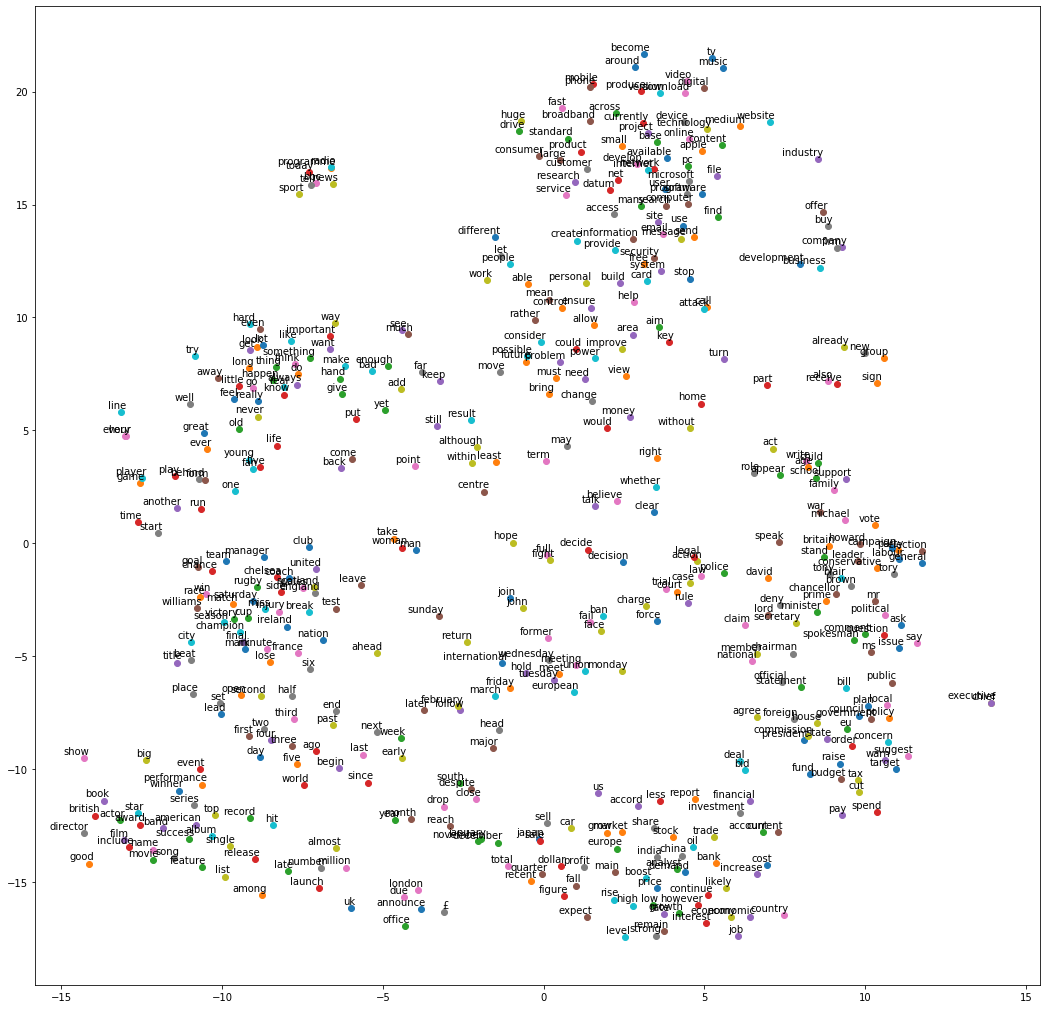

In [31]:
def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
tsne_plot(w2v_model)

In [41]:
labels=[]
tokens=[]
for word in w2v_model.wv.vocab:
    tokens.append(w2v_model[word])
    labels.append(word)

C:\Users\mitta\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [50]:
for x,y in zip(labels,tokens):
    print(x,y, len(y))

tv [-0.01090403  0.09250858  0.11891797 -0.09657215  0.06085359 -0.00656005
 -0.03680244 -0.11696641  0.02123664 -0.04115979 -0.02152404  0.06887064
 -0.00351441 -0.01534953 -0.1772807   0.13287596 -0.00792752  0.00038402
  0.01600716  0.12821916  0.12981431 -0.08172339 -0.04727711 -0.03656797
  0.14448984 -0.22368345 -0.16114159  0.02393367 -0.04543413 -0.10952386
  0.15569273 -0.06215542  0.12357002  0.04312679  0.09108749 -0.01293229
 -0.08862762 -0.02609435 -0.04680702  0.23994863 -0.10290537  0.05582383
  0.2512535  -0.11755954  0.11452544  0.00149844 -0.10542154  0.09412459
 -0.09039732 -0.01735139  0.08669405  0.11294593  0.02260718 -0.14220984
  0.05478004  0.03961792  0.1380682   0.11528438 -0.12785935  0.13491967
 -0.09665262 -0.02019301 -0.23249592 -0.04617439  0.10835903  0.04723171
  0.02997295 -0.03864905  0.06898236 -0.00470206  0.07819733  0.07012511
 -0.02435233 -0.13382104 -0.2716101   0.01108285  0.02435765  0.14029455
  0.04662392 -0.03048474 -0.07355641  0.09710374  0.05859203 -0.01076729
  0.03341062  0.03066615  0.03772709 -0.05543031  0.18270653  0.00958543
 -0.11722356 -0.06852932 -0.09400018 -0.07181793 -0.08096649  0.00482594
 -0.11982225 -0.13304934  0.15618676  0.0504907 ] 100

- The word "Tv" is being converted into vector format, and it has 100 vectors dimensionality.
- The respective word and its vector[word2vec]

In [57]:
w2v_model.wv.vocab

{'tv': <gensim.models.keyedvectors.Vocab at 0x2a73377d5c8>,
 'future': <gensim.models.keyedvectors.Vocab at 0x2a736fad788>,
 'hand': <gensim.models.keyedvectors.Vocab at 0x2a73c6f7388>,
 'home': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee2c8>,
 'system': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee548>,
 'digital': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee108>,
 'video': <gensim.models.keyedvectors.Vocab at 0x2a73c6eef88>,
 'move': <gensim.models.keyedvectors.Vocab at 0x2a73c6eed48>,
 'way': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee208>,
 'people': <gensim.models.keyedvectors.Vocab at 0x2a73c6eecc8>,
 'different': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee4c8>,
 'five': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee8c8>,
 'year': <gensim.models.keyedvectors.Vocab at 0x2a73c6eeb88>,
 'time': <gensim.models.keyedvectors.Vocab at 0x2a73c6ee388>,
 'accord': <gensim.models.keyedvectors.Vocab at 0x2a73c6eec48>,
 'consumer': <gensim.models.keyedvectors.Vocab at 0x2a73